In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import keras_tuner as kt

## Các chỉ số đánh giá

In [2]:
"""
Các chỉ số **Dice Coefficient (DICE), Dice Loss và Intersection over Union (IoU)** thường được sử dụng để đánh giá hiệu suất của các mô hình phân đoạn hình ảnh, đặc biệt trong các nhiệm vụ phân đoạn y tế:
"""

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

## Tiền xử lý dữ liệu

Đang tải no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

Đang tải glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

Đang tải meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

Đang tải pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Số lượng hình ảnh: 4237
Số lượng mặt nạ: 4237
Số lượng nhãn: 4237


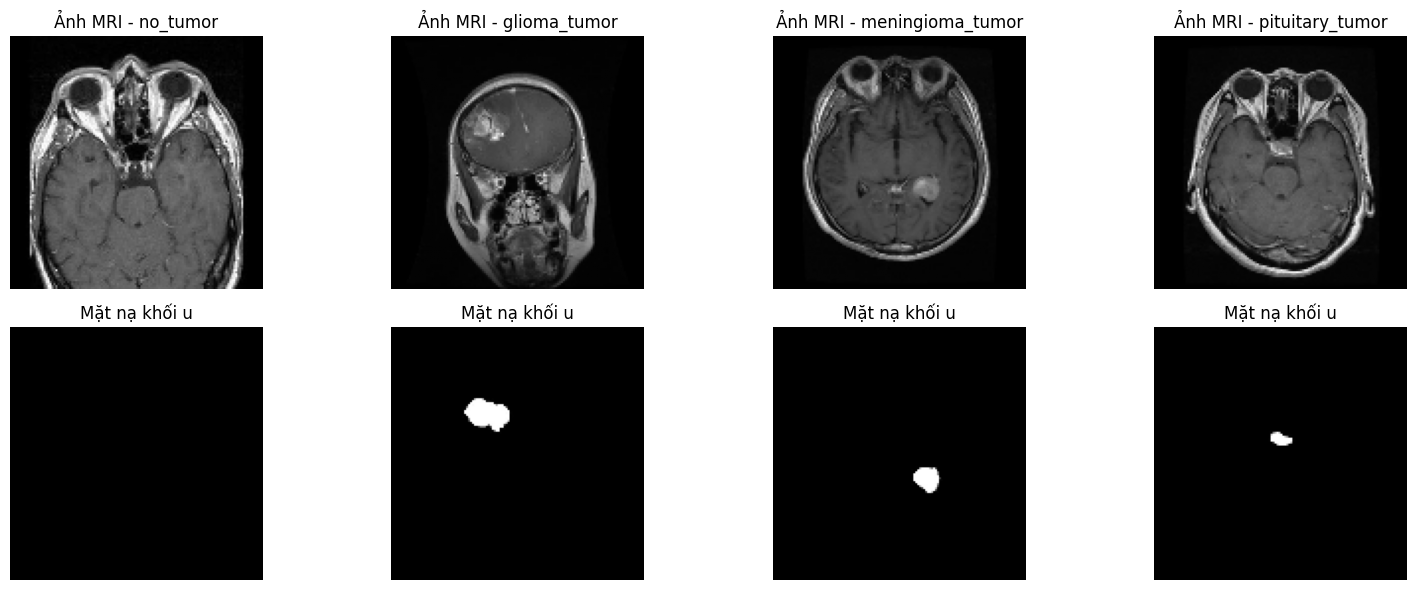

In [4]:
# Đường dẫn truy cập dữ liệu
data_path = "Brain Tumor Segmentation Dataset"
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
images = []
masks = []
labels = []
target_size = (128, 128)

# Bước 1: Tải hình ảnh và mặt nạ
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        for image_name in tqdm(os.listdir(image_folder), desc=f"Đang tải {class_name}"):
            if image_name.endswith('.jpg'):
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)  # Thay đổi kích thước hình ảnh
                image = image / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                
                mask_name = image_name
                mask_path = os.path.join(mask_folder, mask_name)
                
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size)  # Thay đổi kích thước mặt nạ
                    mask = mask / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                    
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))
                else:
                    print(f"Mặt nạ bị thiếu cho hình ảnh: {image_name}")

# Bước 2: Chuyển đổi danh sách thành mảng NumPy và định dạng lại
images = np.array(images).reshape(-1, 128, 128, 1)  # Thêm chiều kênh (channel)
masks = np.array(masks).reshape(-1, 128, 128, 1)    # Thêm chiều kênh (channel)
labels = np.array(labels)

print(f"Số lượng hình ảnh: {len(images)}")
print(f"Số lượng mặt nạ: {len(masks)}")
print(f"Số lượng nhãn: {len(labels)}")

# Show ảnh minh họa
num_classes = len(classes)
# Tìm chỉ số đầu tiên của mỗi class trong mảng labels
fig, axes = plt.subplots(nrows=2, ncols=num_classes, figsize=(4 * num_classes, 6))

for class_index, class_name in enumerate(classes):
    # Lấy index đầu tiên của ảnh thuộc class hiện tại
    idx = np.where(labels == class_index)[0][0]
    
    # Hàng trên: ảnh MRI
    axes[0, class_index].imshow(images[idx].squeeze(), cmap='gray')
    axes[0, class_index].set_title(f"Ảnh MRI - {class_name}")
    axes[0, class_index].axis('off')
    
    # Hàng dưới: mặt nạ tương ứng
    axes[1, class_index].imshow(masks[idx].squeeze(), cmap='gray')
    axes[1, class_index].set_title("Mặt nạ khối u")
    axes[1, class_index].axis('off')

plt.tight_layout()
plt.show()


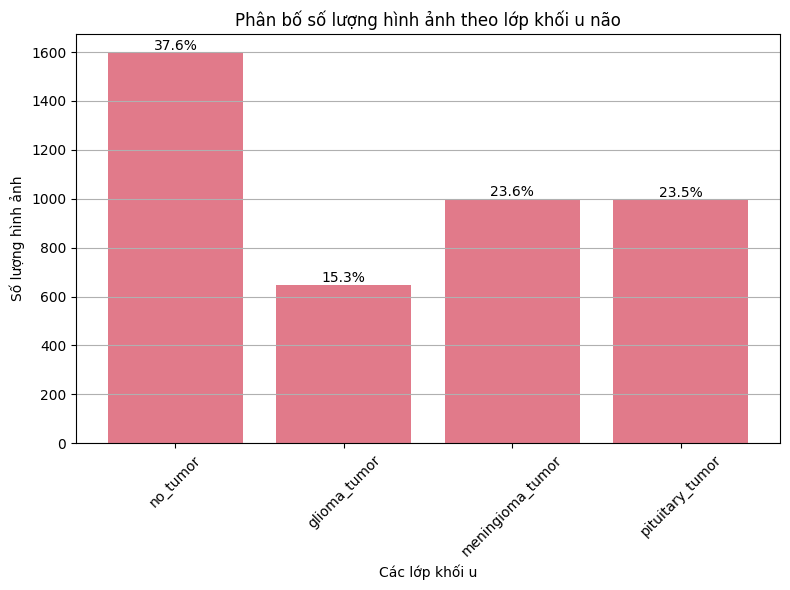

'\nNhận xét: Các lớp thể hiện sự phân bố không cân bằng, với lớp "no tumor" chiếm tỷ lệ đáng kể (37.6%), \ntrong khi các loại khối u khác có tỷ lệ thấp hơn. Sự mất cân bằng này có thể ảnh hưởng đến hiệu suất của mô hình U-Net.\n'

In [9]:
# Bước 3: Kiểm tra trực quan - Phân bố dữ liệu
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')
plt.xlabel('Các lớp khối u')
plt.ylabel("Số lượng hình ảnh")
plt.title("Phân bố số lượng hình ảnh theo lớp khối u não")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

"""
Nhận xét: Các lớp thể hiện sự phân bố không cân bằng, với lớp "no tumor" chiếm tỷ lệ đáng kể (37.6%), 
trong khi các loại khối u khác có tỷ lệ thấp hơn. Sự mất cân bằng này có thể ảnh hưởng đến hiệu suất của mô hình U-Net.
"""


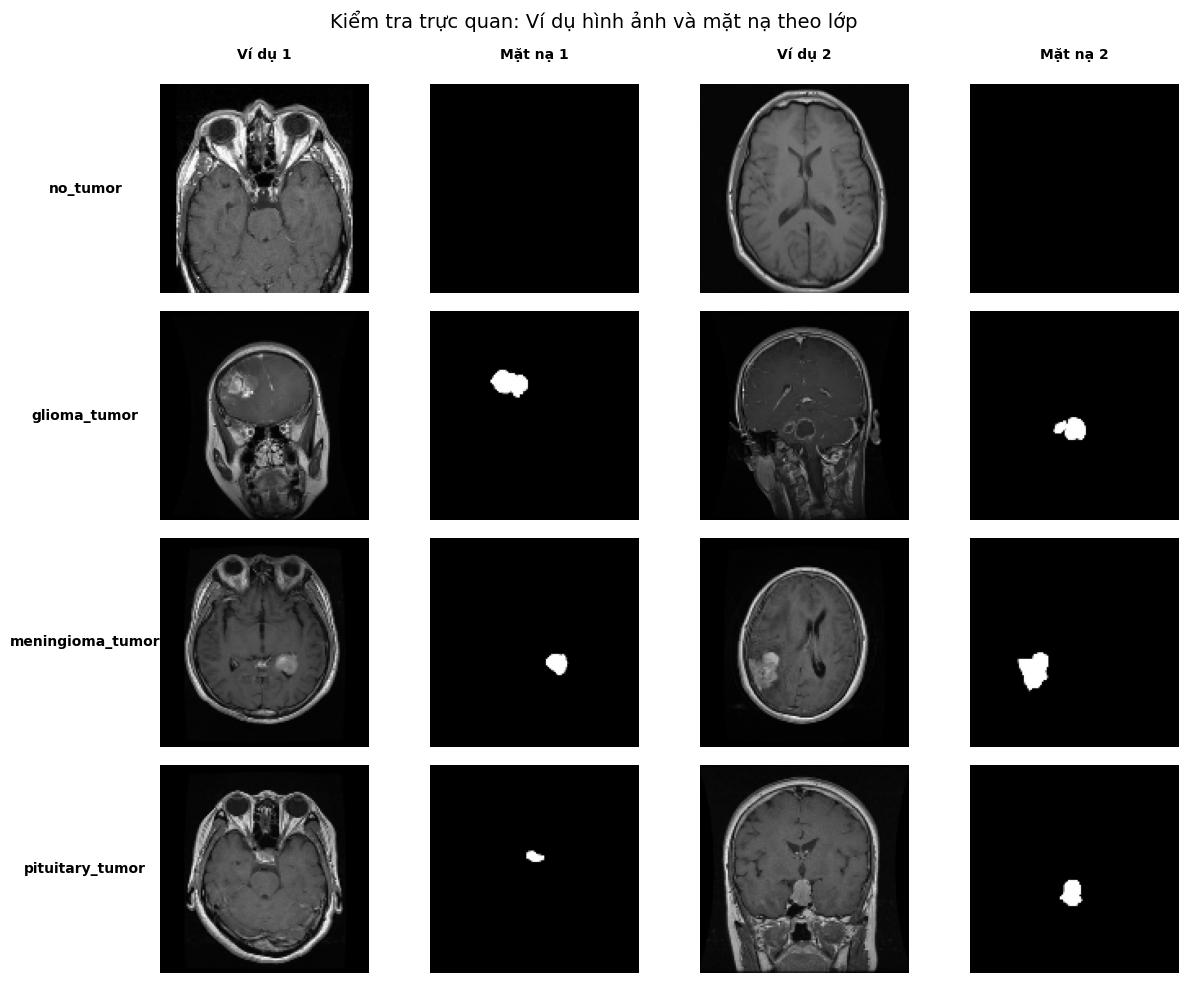

In [10]:
# Bước 4: Kiểm tra trực quan - Hiển thị ví dụ hình ảnh và mặt nạ trước khi chia dữ liệu
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(12, 10), 
                       gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')
axs[0, 1].text(0.5, 0.5, "Ví dụ 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')
axs[0, 2].text(0.5, 0.5, "Mặt nạ 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')
axs[0, 3].text(0.5, 0.5, "Ví dụ 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')
axs[0, 4].text(0.5, 0.5, "Mặt nạ 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')

for i, class_name in enumerate(classes):
    class_index = classes.index(class_name)
    example_index1 = np.where(labels == class_index)[0][0]  # Ví dụ đầu tiên
    example_index2 = np.where(labels == class_index)[0][min(2, len(np.where(labels == class_index)[0])-1)]  # Ví dụ thứ ba (nếu có)
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    
    axs[i + 1, 1].imshow(image1.squeeze(), cmap='gray')
    axs[i + 1, 1].axis('off')
    axs[i + 1, 2].imshow(mask1.squeeze(), cmap='gray')
    axs[i + 1, 2].axis('off')
    axs[i + 1, 3].imshow(image2.squeeze(), cmap='gray')
    axs[i + 1, 3].axis('off')
    axs[i + 1, 4].imshow(mask2.squeeze(), cmap='gray')
    axs[i + 1, 4].axis('off')
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')

plt.suptitle("Kiểm tra trực quan: Ví dụ hình ảnh và mặt nạ theo lớp", fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
# Bước 5: Chia dữ liệu thành tập huấn luyện, test và tập xác thực
images_train, images_temp, masks_train, masks_temp, labels_train, labels_temp = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels
)

images_val, images_test, masks_val, masks_test, labels_val, labels_test = train_test_split(
    images_temp, masks_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
)

print(f"Bộ dữ liệu huấn luyện - Hình ảnh: {images_train.shape}, Mặt nạ: {masks_train.shape}, Nhãn: {labels_train.shape}")
print(f"Bộ dữ liệu test - Hình ảnh: {images_test.shape}, Mặt nạ: {masks_test.shape}, Nhãn: {labels_test.shape}")
print(f"Bộ dữ liệu xác thực - Hình ảnh: {images_val.shape}, Mặt nạ: {masks_val.shape}, Nhãn: {labels_val.shape}")


Bộ dữ liệu huấn luyện - Hình ảnh: (2965, 128, 128, 1), Mặt nạ: (2965, 128, 128, 1), Nhãn: (2965,)
Bộ dữ liệu test - Hình ảnh: (636, 128, 128, 1), Mặt nạ: (636, 128, 128, 1), Nhãn: (636,)
Bộ dữ liệu xác thực - Hình ảnh: (636, 128, 128, 1), Mặt nạ: (636, 128, 128, 1), Nhãn: (636,)


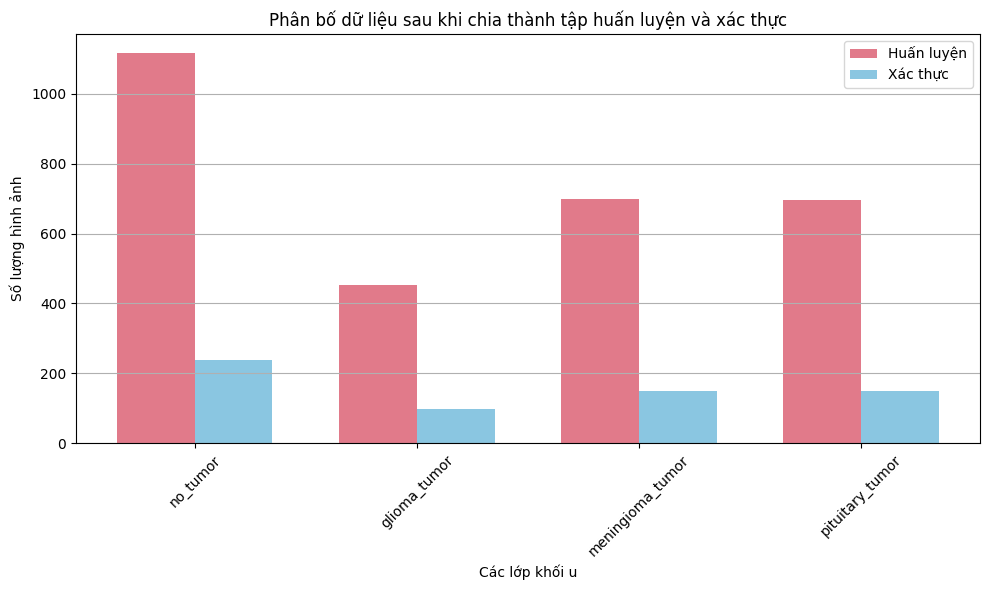

In [12]:
# Bước 6: Kiểm tra trực quan - Phân bố sau khi chia dữ liệu
def plot_split_distribution(labels_train, labels_val, classes):
    train_counts = np.bincount(labels_train)
    val_counts = np.bincount(labels_val)
    class_labels = [classes[i] for i in range(len(classes))]
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, train_counts, width, label='Huấn luyện', color='#E17A8A')
    ax.bar(x + width/2, val_counts, width, label='Xác thực', color='#8AC6E1')
    
    ax.set_xlabel('Các lớp khối u')
    ax.set_ylabel('Số lượng hình ảnh')
    ax.set_title('Phân bố dữ liệu sau khi chia thành tập huấn luyện và xác thực')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.legend()
    ax.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

plot_split_distribution(labels_train, labels_val, classes)


In [13]:
# Bước 7: Định nghĩa generator tăng cường dữ liệu
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield img_batch, mask_batch


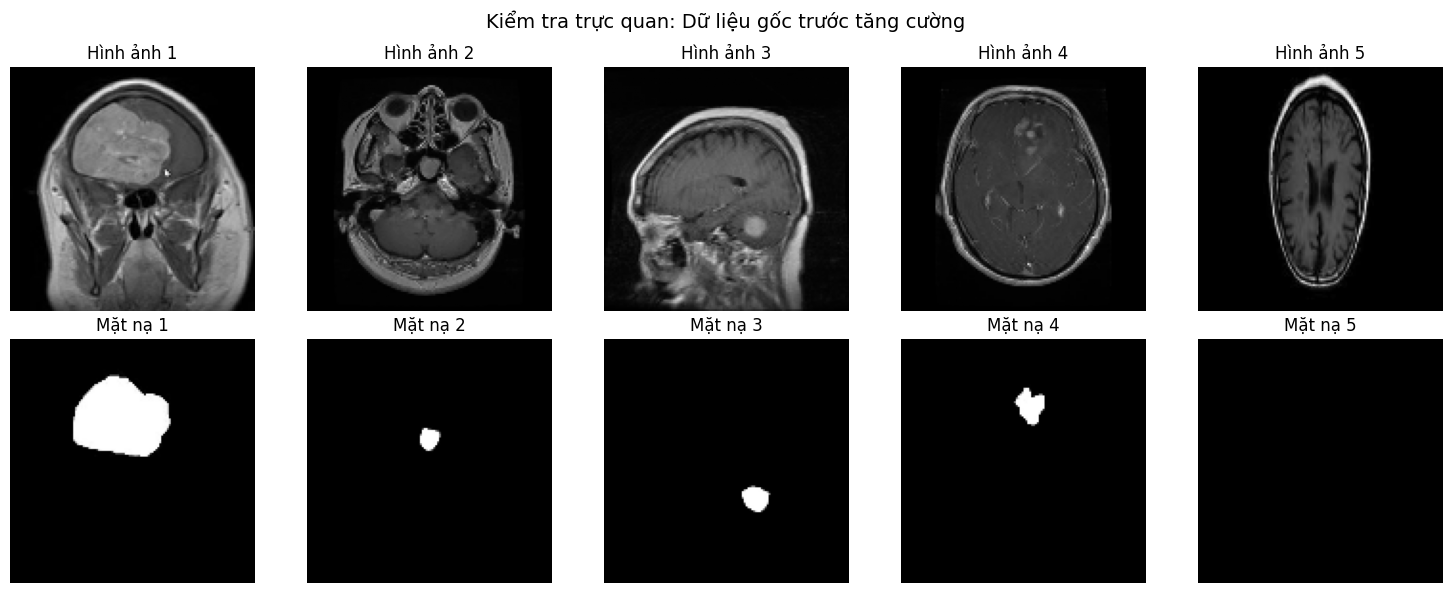

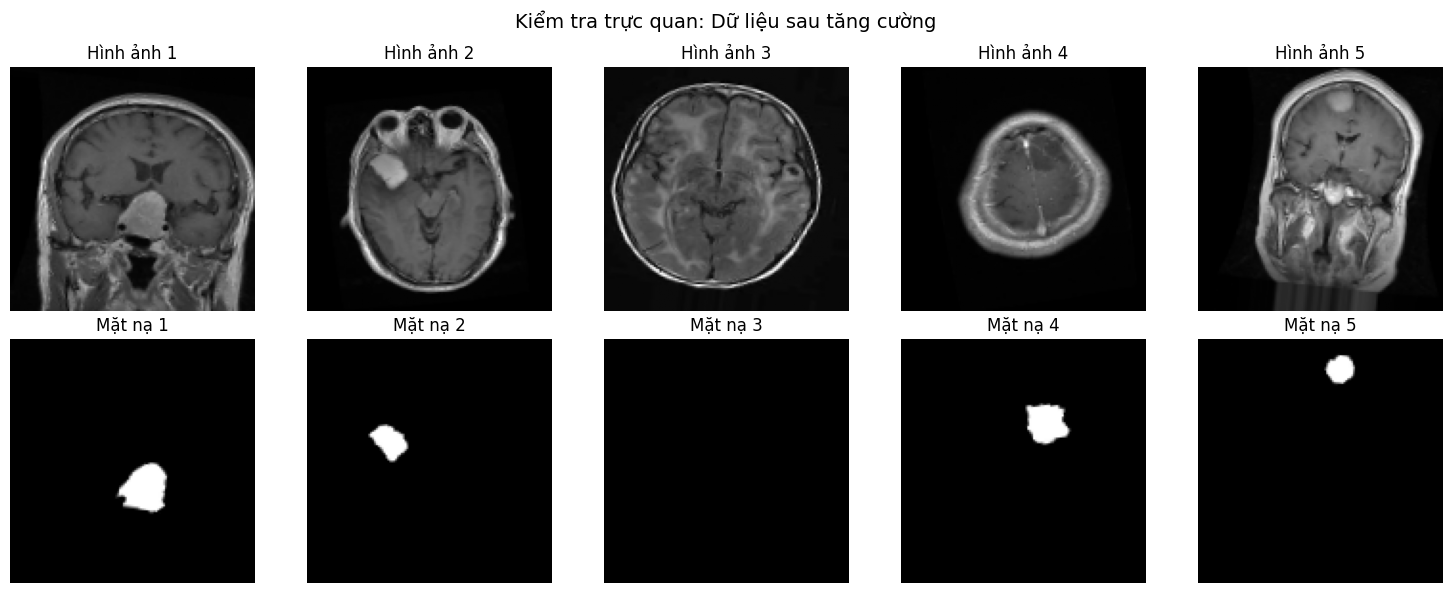

In [14]:
# Bước 8: Kiểm tra trực quan - Hiển thị dữ liệu sau tăng cường
def plot_images(images, masks, num_images=5, title="Hình ảnh và mặt nạ"):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(f'Hình ảnh {i+1}')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title(f'Mặt nạ {i+1}')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Kiểm tra dữ liệu gốc trước tăng cường
plot_images(images_train[:5], masks_train[:5], num_images=5, title="Kiểm tra trực quan: Dữ liệu gốc trước tăng cường")

# Kiểm tra dữ liệu sau tăng cường từ generator
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))
plot_images(images_batch, masks_batch, num_images=5, title="Kiểm tra trực quan: Dữ liệu sau tăng cường")


## Huấn luyện mô hình

In [18]:
def unet_model(input_shape):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model



In [ ]:
input_shape = (128, 128, 1)
model = unet_model(input_shape)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])

model_checkpoint = ModelCheckpoint('best_unetmodel.keras', monitor='val_dice_coefficient', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_dice_coefficient', patience=10, mode='max', verbose=1)

# Huấn luyện
batch_size = 32
train_gen = train_generator(images_train, masks_train, batch_size=batch_size)

history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // batch_size,
    epochs=100,
    validation_data=(images_val, masks_val),
    callbacks=[model_checkpoint, early_stopping]
)

# Đánh giá
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Mất mát huấn luyện: {train_loss:.4f}')
print(f'Độ chính xác huấn luyện: {train_accuracy:.4f}')
print(f'Hệ số Dice huấn luyện: {train_dice_coef:.4f}')
print(f'Hệ số IoU huấn luyện: {train_iou_coef:.4f}')

val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Mất mát xác thực: {val_loss:.4f}')
print(f'Độ chính xác xác thực: {val_accuracy:.4f}')
print(f'Hệ số Dice xác thực: {val_dice_coef:.4f}')
print(f'Hệ số IoU xác thực: {val_iou_coef:.4f}')

# Biểu đồ
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(history.history['loss'], label='Mất mát huấn luyện')
axs[0, 0].plot(history.history['val_loss'], label='Mất mát xác thực')
axs[0, 0].set_title('Mất mát qua các Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Mất mát')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()
axs[0, 1].plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
axs[0, 1].plot(history.history['val_accuracy'], label='Độ chính xác xác thực')
axs[0, 1].set_title('Độ chính xác qua các Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Độ chính xác')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].legend()
axs[1, 0].plot(history.history['dice_coefficient'], label='Hệ số Dice huấn luyện')
axs[1, 0].plot(history.history['val_dice_coefficient'], label='Hệ số Dice xác thực')
axs[1, 0].set_title('Hệ số Dice qua các Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Hệ số Dice')
axs[1, 0].legend()
axs[1, 1].plot(history.history['iou'], label='IoU huấn luyện')
axs[1, 1].plot(history.history['val_iou'], label='IoU xác thực')
axs[1, 1].set_title('IoU qua các Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].legend()
plt.tight_layout()
plt.show()


## Test mô hình

20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step


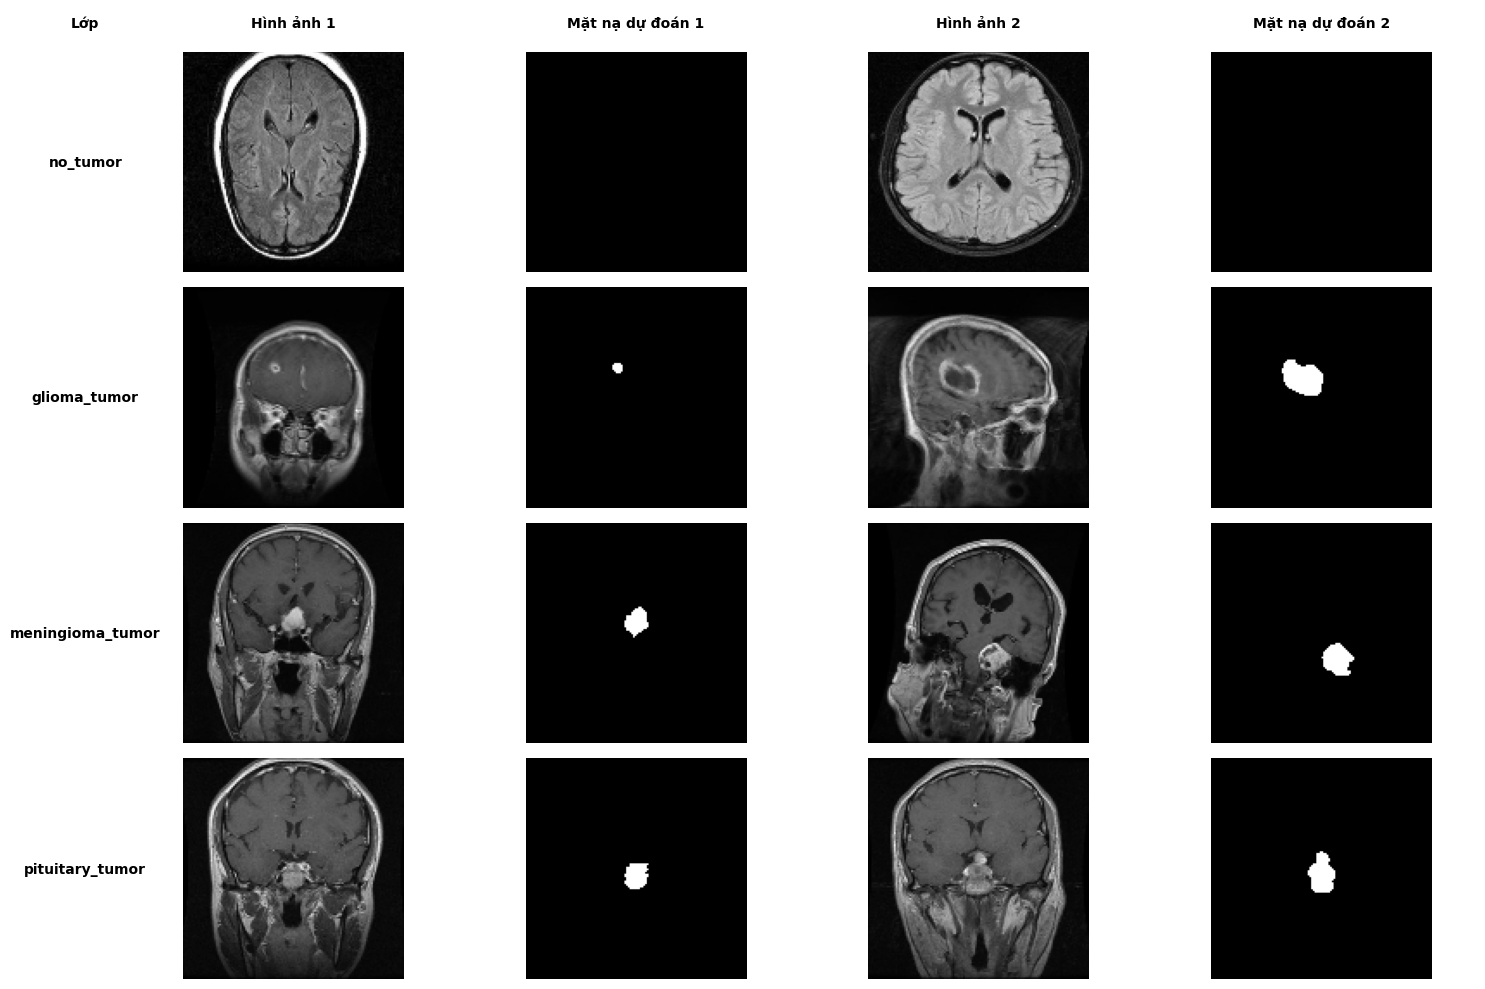

In [21]:
# Hàm dự đoán với mô hình đã lưu
def predict_with_saved_model(model_path, test_images):
    loaded_model = models.load_model(model_path, custom_objects={
        'dice_coefficient': dice_coefficient,
        'iou': iou
    })
    predictions = loaded_model.predict(test_images)
    predictions = (predictions > 0.5).astype(np.uint8)  # Chuyển về nhị phân (0 hoặc 1)
    return predictions

# Dự đoán với mô hình đã lưu
test_predictions = predict_with_saved_model('best_unetmodel.keras', images_test)

# Hiển thị kết quả
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(15, 10), 
                       gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})

# Tiêu đề
titles = ["Lớp", "Hình ảnh 1", "Mặt nạ dự đoán 1", "Hình ảnh 2", "Mặt nạ dự đoán 2"]
for j in range(5):
    axs[0, j].text(0.5, 0.5, titles[j], fontsize=10, ha='center', va='center', fontweight='bold')
    axs[0, j].axis('off')

# Hiển thị các kết quả dự đoán cho từng lớp
for i, class_name in enumerate(classes):
    class_indices = [j for j, label in enumerate(labels_test) if label == i]
    if len(class_indices) >= 2:
        example_index1 = class_indices[0]
        example_index2 = class_indices[1]
        
        # Tiêu đề của lớp
        axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
        axs[i + 1, 0].axis('off')
        
        # Hình ảnh 1 và mặt nạ dự đoán 1
        axs[i + 1, 1].imshow(images_test[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 1].axis('off')
        axs[i + 1, 2].imshow(test_predictions[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 2].axis('off')
        
        # Hình ảnh 2 và mặt nạ dự đoán 2
        axs[i + 1, 3].imshow(images_test[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 3].axis('off')
        axs[i + 1, 4].imshow(test_predictions[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 4].axis('off')

# Điều chỉnh và hiển thị biểu đồ
plt.tight_layout()
plt.show()